In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/blob/main/07_11_23_day2_ml_basics_dynamical_systems/code/diy_notebooks/1_MNIST_from_Scratch_Colab.ipynb)


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the MNIST dataset.
It has the classes: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. The images in MNIST are of
size 1x28x28, i.e. grayscale images of 28x28 pixels in size.


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the MNIST training and test datasets using
   ``torchvision``
2. Define a Fully-Connected Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize MNIST

Using ``torchvision``, it’s extremely easy to load MNIST.


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = [f"{num}" for num in range(10)]

Let us show some of the training images, for fun.



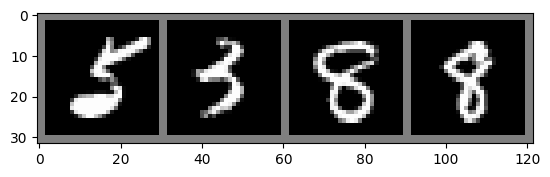

5     3     8     8    


In [36]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Fully-Connected Neural Network



In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimension except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.782
[1,  4000] loss: 0.389
[1,  6000] loss: 0.312
[1,  8000] loss: 0.267
[1, 10000] loss: 0.235
[1, 12000] loss: 0.221
[1, 14000] loss: 0.202
[2,  2000] loss: 0.170
[2,  4000] loss: 0.170
[2,  6000] loss: 0.162
[2,  8000] loss: 0.148
[2, 10000] loss: 0.133
[2, 12000] loss: 0.134
[2, 14000] loss: 0.140
Finished Training


Let's quickly save our trained model:



In [10]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



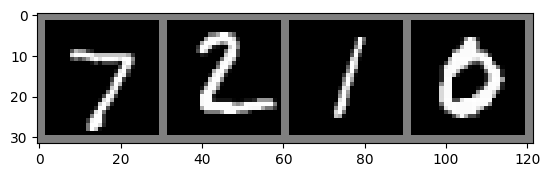

GroundTruth:  7     2     1     0    


In [37]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [40]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 98.6 %
Accuracy for class: 1     is 98.8 %
Accuracy for class: 2     is 94.2 %
Accuracy for class: 3     is 88.6 %
Accuracy for class: 4     is 96.9 %
Accuracy for class: 5     is 96.1 %
Accuracy for class: 6     is 97.2 %
Accuracy for class: 7     is 96.5 %
Accuracy for class: 8     is 89.7 %
Accuracy for class: 9     is 95.6 %


# Building a Classifier from Scratch
---

Now that you've built and trained a neural network for classification on MNIST, you will build the same network from the ground up. We will first derive the loss function, derive the backpropagation rule, create the optimizer, and run the training. By building the neural network from scratch, you'll have how a neural network operates internally—giving you a better idea why different failure modes may occur.

## 1. Deriving the loss function

The binary cross-entropy is directly related to maximum likelihood estimation on the logistic distribution
$$
{\arg\max}_{\theta} \mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(z)]
$$

### Step 1.
For $\hat{p}_\text{data}$ is a categorical distribution, that is, $\hat{p}_\text{data} = (p_1, p_2, \ldots, p_k)$, what is the likelihood function
$$
\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(x, y)]
$$

Answer:
$$
\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(x, y)] = \sum_{i} \sum_j p_j^{(i)} \log p_\theta(z)_j^{(i)}
$$

### Step 2.
If $\hat{p}_\text{data} = (0, \ldots, 1, \ldots, 0)$, that is, $\hat{p}_\text{data} = 1$ for some $i$, what is the likelihood function?

Answer:
$$
\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(x, y)] = \sum_{i} p_j^{(i)} \log p_\theta(z)_j^{(i)}
$$

### Step 3.
What is the gradient of likelihood function with respect to $z$?

Answer:
$$
\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(x, y)] = \sum_{i} \frac{p_j^{(i)}}{p_\theta(z)_j^{(i)}} \frac{\partial p_\theta(z)}{\partial z}
$$

### Step 4.
What is the gradient of the softmax distribution
$$
p_\theta(z) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

Answer:
$$
\frac{\partial p_\theta(z)}{\partial z} = p_\theta(z)_i (\delta_{ij} - p_\theta(z)_j)
$$

### Step 5.
What is the gradient of the negative log likelihood function
$$
-\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(z)]
$$

Answer:
$$
\frac{\partial}{\partial z}\left[-\mathbb{E}_{\hat{p}_\text{data}}[\log p_\theta(z)] \right] = p_\theta(z)_i - p_i
$$

## 2. Deriving the backpropagation rule

### Step 1.
What are the gradients
$$
\frac{\partial}{\partial W} [Wz + b], \frac{\partial}{\partial z} [Wz + b], \frac{\partial}{\partial b}[Wz + b]?
$$

Answer:
$$
\frac{\partial}{\partial W} [Wz + b] = 1^T z, \frac{\partial}{\partial z} [Wz + b] = W, \frac{\partial}{\partial b}[Wz + b]=1
$$

### What is the gradient of the activation function
$$
\sigma(z) = \max{0, z}?
$$

Answer:
$$
\frac{\partial \sigma}{\partial z} = \mathbb{I}[z > 0]
$$
where $\mathbb{I}$ is the indicator function.

## 3. Writing the backpropagation code

In this section, you will write the code to calculate the forward and backward passes of the neural network.

In [17]:
class NLLLoss:
  def __call__(self, x):
    return self.forward(x)

  def forward(self, outputs, labels):
    # Calculate the softmax distribution

    # Calculate the negative log likelihood function
    pass

  def backward(self, outputs, labels):
    # Calculate the gradient of the negative log likelihood function
    pass


In [18]:
class Linear:
  def __init__(self, dim_in, dim_out):
    # set the weight and bias
    # self.W = ?
    # self.b = ?
    pass

  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Calculate W*x + b
    pass

  def backward(self, z):
    # Calculate d/dz

    # Calculate d/dW

    # Calculate d/db
    pass

In [19]:
class ReLU:
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    # Calculate max{0, x}
    pass

  def backward(self, z):
    # Calculate d/dz max{0, z}
    pass

In [20]:
class Net:
    def __init__(self):
        self.fc1 = Linear(28 * 28, 120)
        self.fc2 = Linear(120, 256)
        self.fc3 = Linear(256, 10)
        self.relu = ReLU()
        self.parameters = {
            "fc1.W": self.fc1.W,
            "fc1.b": self.fc1.b,
            "fc2.W": self.fc2.W,
            "fc2.b": self.fc2.b,
            "fc3.W": self.fc3.W,
            "fc3.b": self.fc3.b
        }
        self._grad = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1)) # flatten all dimension except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def backward(self, z):
        self._grad = {}
        dz, dW, db = self.fc3.backward(z)
        self._grad["fc3.W"] = dW
        self._grad["fc3.b"] = db
        dz = self.relu(z)
        dz, dW, db = self.fc2.backward(z)
        self._grad["fc2.W"] = dW
        self._grad["fc2.b"] = db
        dz = self.relu.backward(z)
        dz, dW, db = self.fc1.backward(z)
        self._grad["fc1.W"] = dW
        self._grad["fc1.b"] = db


## 4. Writing the optimizer

### Step 1.
In this example, we will be implementing stochastic gradient descent
$$
  \theta_{t+1} \leftarrow \theta_t - \nabla_\theta (- \mathbb{E}_{p_\text{data}}[\log p_\theta(z(x))])
$$

In [21]:
class Optimizer:
  def __init__(self, lr=1e-3):
    # Keep track of a dictionary of the model's parameters
    # self.parameters = ?

    # Set the learning rate
    self.lr = lr
    pass

  def step(self, gradients):
    for k in self.parameters:
      self.parameters[k] += self.lr*gradients[k]



## 5. Run the training


In [22]:
net = Net()
loss = NLLLoss()

AttributeError: 'Linear' object has no attribute 'W'

In [ ]:
with torch.no_grad():
  for epoch in range(2):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # forward + backward + optimize
          outputs = net(inputs)
          loss = loss(outputs, labels)
          dz = loss.backward(outputs, labels)
          net.backward(dz)
          optimizer.step(net._grad)

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')